In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
import functions.sequencefunctions as sf

In [2]:

vdj = pd.read_csv('../data/vdj_cleaned_set_with_stitchr_seq.csv', index_col=0).dropna(subset = ['TCRa', 'TCRb'], how='any')
print(vdj.shape)
vdj0 = vdj.drop_duplicates(subset=['TCRa', 'TCRb', 'Epitope'])
vdj0 = vdj0.loc[vdj0['Epitope'] != 'KLGGALQAK'] # because too big - takes forever
print('keep only complete sequences: ', vdj0.shape)
counts = vdj0.Epitope.value_counts()
# not_too_big = [x for x in counts.keys() if counts[x]<10000 and counts[x] > 100]
not_too_small = [x for x in counts.index if counts[x] > 100]
vdj1 = vdj0.loc[vdj.Epitope.isin(not_too_small)]
print('finding cdr1s...')
vdj1['cdr1a_IMGTgaps'] = [x if pd.isna(x) else sf.get_cdr1_seq_with_gaps(x.strip()) for x in vdj1.TCRa]
vdj1['cdr1b_IMGTgaps'] = [x if pd.isna(x) else sf.get_cdr1_seq_with_gaps(x.strip()) for x in vdj1.TCRb]
print('finding cdr2s...')
vdj1['cdr2a_IMGTgaps'] = [x if pd.isna(x) else sf.get_cdr2_seq_with_gaps(x.strip()) for x in vdj1.TCRa]
vdj1['cdr2b_IMGTgaps'] = [x if pd.isna(x) else sf.get_cdr2_seq_with_gaps(x.strip()) for x in vdj1.TCRb]
print('finding cdr3s...')
vdj1['cdr3a_IMGTgaps'] = [x if pd.isna(x) else sf.get_cdr3_seq_with_gaps(x.strip()) for x in vdj1.TCRa]
vdj1['cdr3b_IMGTgaps'] = [x if pd.isna(x) else sf.get_cdr3_seq_with_gaps(x.strip()) for x in vdj1.TCRb]

print('run checks...')
assert (vdj1.dropna(subset=['cdr1a_IMGTgaps']).apply(lambda x: x.cdr3a_IMGTgaps.replace('-', '') in x.TCRa, axis=1)).all()
assert (vdj1.dropna(subset=['cdr1b_IMGTgaps']).apply(lambda x: x.cdr3b_IMGTgaps.replace('-', '') in x.TCRb, axis=1)).all()
assert (vdj1.dropna(subset=['cdr2a_IMGTgaps']).apply(lambda x: x.cdr3a_IMGTgaps.replace('-', '') in x.TCRa, axis=1)).all()
assert (vdj1.dropna(subset=['cdr2b_IMGTgaps']).apply(lambda x: x.cdr3b_IMGTgaps.replace('-', '') in x.TCRb, axis=1)).all()
assert (vdj1.dropna(subset=['cdr3a_IMGTgaps']).apply(lambda x: x.cdr3a_IMGTgaps.replace('-', '') in x.TCRa, axis=1)).all()
assert (vdj1.dropna(subset=['cdr3b_IMGTgaps']).apply(lambda x: x.cdr3b_IMGTgaps.replace('-', '') in x.TCRb, axis=1)).all()

(23503, 25)
keep only complete sequences:  (9883, 25)
finding cdr1s...
finding cdr2s...
finding cdr3s...
run checks...


In [3]:
vdj2 = vdj1.dropna(subset=['cdr1a_IMGTgaps', 'cdr1b_IMGTgaps', 'cdr2a_IMGTgaps', 'cdr2b_IMGTgaps', 'cdr3a_IMGTgaps', 'cdr3b_IMGTgaps'])
# remove cdr3s that do not start with C
vdj3 = vdj2.loc[(vdj2['CDR3-a'].str[0] == 'C') & (vdj2['CDR3-b'].str[0] == 'C')]
vdj3['len_cdr3a'] = [len(x) for x in vdj3['CDR3-a']]
vdj3['len_cdr3b'] = [len(x) for x in vdj3['CDR3-b']]
vdj3['len1_cdr3a'] = [len(x) for x in vdj3['cdr3a_IMGTgaps'].str.replace('-','')]
vdj3['len1_cdr3b'] = [len(x) for x in vdj3['cdr3b_IMGTgaps'].str.replace('-','')]


/tmp/ipykernel_3545737/1544846935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdj3['len_cdr3a'] = [len(x) for x in vdj3['CDR3-a']]
/tmp/ipykernel_3545737/1544846935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdj3['len_cdr3b'] = [len(x) for x in vdj3['CDR3-b']]
/tmp/ipykernel_3545737/1544846935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [4]:
vdj3.loc[(vdj3['len_cdr3a'] != vdj3['len1_cdr3a'])][['CDR3-a', 'cdr3a_IMGTgaps']]

,CDR3-a,cdr3a_IMGTgaps
1073,CAVGHELYSGGGDDGLTL,CAVGHELYSGGGDDGLTLTF


In [5]:
# remove sequences that are stupidly long
cdr3a_len = vdj3.len1_cdr3a.value_counts().reset_index() # only 18 with length > 19
cdr3b_len = vdj3.len1_cdr3b.value_counts().reset_index() # only 39 with length > 19

In [6]:
vdj4 = vdj3.loc[(vdj3.len1_cdr3a < 20) & (vdj3.len1_cdr3b < 20)]
print(vdj4.shape)

(9785, 35)


In [7]:
cdr3a_len.columns = ['length', 'count']
cdr3a_len = cdr3a_len.sort_values(by = 'length')

cdr3b_len.columns = ['length', 'count']
cdr3b_len = cdr3b_len.sort_values(by = 'length')

print(cdr3a_len)

    length  count
13       7      3
11       8     13
10       9     38
7       10    348
4       11    890
3       12   1578
0       13   2144
1       14   1764
2       15   1738
5       16    600
6       17    523
8       18    136
9       19     58
12      20      9
15      21      2
14      22      3
18      23      1
16      24      2
17      25      2


/tmp/ipykernel_3545737/537091079.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)


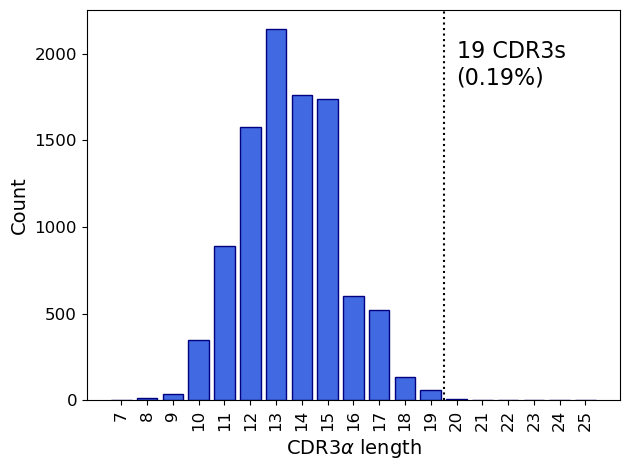

In [8]:
ax = plt.subplot()

ax.bar(x = cdr3a_len['length'], height = cdr3a_len['count'], color = 'royalblue', edgecolor = 'navy')
ax.axvline(19.5, ls = ':', c = 'k')
count = cdr3a_len.loc[cdr3a_len['length'] >= 20]['count'].sum()
tot = cdr3a_len['count'].sum()
prop = round(100*count / tot,2)
ax.text(x = 20, y = 0.85*max(cdr3a_len['count']), 
        s = str(count) + ' CDR3s \n(' + str(prop) + '%)' , fontsize = 16)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel(r'CDR3$\alpha$ length', fontsize = 14)
min_x = min(cdr3a_len['length'])
max_x = max(cdr3a_len['length'])
ax.set_xticks(range(min_x, max_x + 1))
ax.set_xticklabels(labels = list(range(min_x, max_x + 1)), fontsize = 12, rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
plt.tight_layout()
plt.savefig('../figures/CDR3a_length_histogram.png')
plt.show()

/tmp/ipykernel_3545737/3889669486.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)


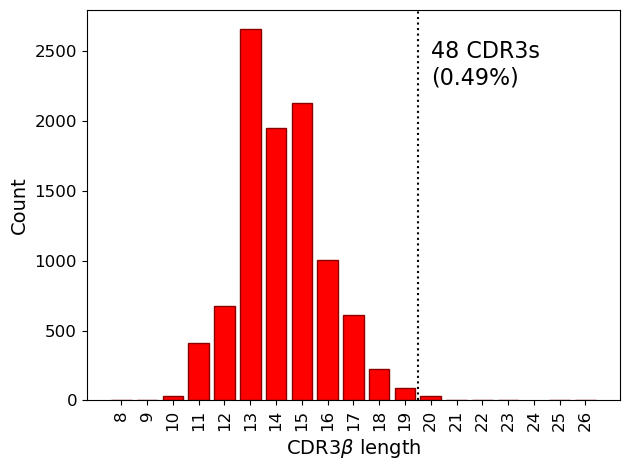

In [9]:
ax = plt.subplot()

ax.bar(x = cdr3b_len['length'], height = cdr3b_len['count'], color = 'r', edgecolor = 'darkred')
ax.axvline(19.5, ls = ':', c = 'k')
count = cdr3b_len.loc[cdr3b_len['length'] >= 20]['count'].sum()
tot = cdr3b_len['count'].sum()
prop = round(100*count / tot,2)
ax.text(x = 20, y = 0.85*max(cdr3b_len['count']), 
        s = str(count) + ' CDR3s \n(' + str(prop) + '%)' , fontsize = 16)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel(r'CDR3$\beta$ length', fontsize = 14)
min_x = min(cdr3b_len['length'])
max_x = max(cdr3b_len['length'])
ax.set_xticks(range(min_x, max_x + 1))
ax.set_xticklabels(labels = list(range(min_x, max_x + 1)), fontsize = 12, rotation = 90)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
plt.tight_layout()
plt.savefig('../figures/CDR3b_length_histogram.png')
plt.show()

In [10]:
# either CDR3 too long

print(100*vdj3.loc[(vdj3.len1_cdr3a >= 20) | (vdj3.len1_cdr3b >= 20)].shape[0]/vdj3.shape[0])
print(vdj3.loc[(vdj3.len1_cdr3a >= 20) | (vdj3.len1_cdr3b >= 20)].shape[0])
print(vdj3.shape[0])

0.6800649614291514
67
9852
